In [43]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from scipy.signal import find_peaks
from scipy.signal import wiener
from scipy.signal import butter, filtfilt
from pathlib  import Path
from invisible_cities.core.core_functions import in_range
from invisible_cities.cities.components   import deconv_pmt
import sys
from datetime import datetime


In [9]:
def find_highest_wf(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    index = np.argmax(np.max(wfs, axis=1))
    return wfs[index]

In [72]:
def sum_wf(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]

    element_wise_sum = np.zeros_like(wfs[0],dtype=np.int64)

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def sum_wf(wfs):
    element_wise_sum = np.zeros_like(wfs[0])

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

In [11]:
path = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"

raw_evts = pd.read_hdf(path, '/Run/events')
display(raw_evts)
print(raw_evts.evt_number.unique())

raw_evts = load_dst(path, 'Run', 'events')
nrwfs = len(raw_evts.evt_number.unique())
print("Number of Waveforms:", nrwfs)


,evt_number,timestamp
0,2,1717753687489
1,9,1717753687848
2,16,1717753688115
3,23,1717753688688
4,30,1717753688983
...,...,...
81,569,1717753717928
82,576,1717753718190
83,583,1717753718662
84,590,1717753719011


[  2   9  16  23  30  37  44  51  58  65  72  79  86  93 100 107 114 121
 128 135 142 149 156 163 170 177 184 191 198 205 212 219 226 233 240 247
 254 261 268 275 282 289 296 303 310 317 324 331 338 345 352 359 366 373
 380 387 394 401 408 415 422 429 436 443 450 457 464 471 478 485 492 499
 506 513 520 527 534 541 548 555 562 569 576 583 590 597]
Number of Waveforms: 86


In [12]:
# Create a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the low-pass filter
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


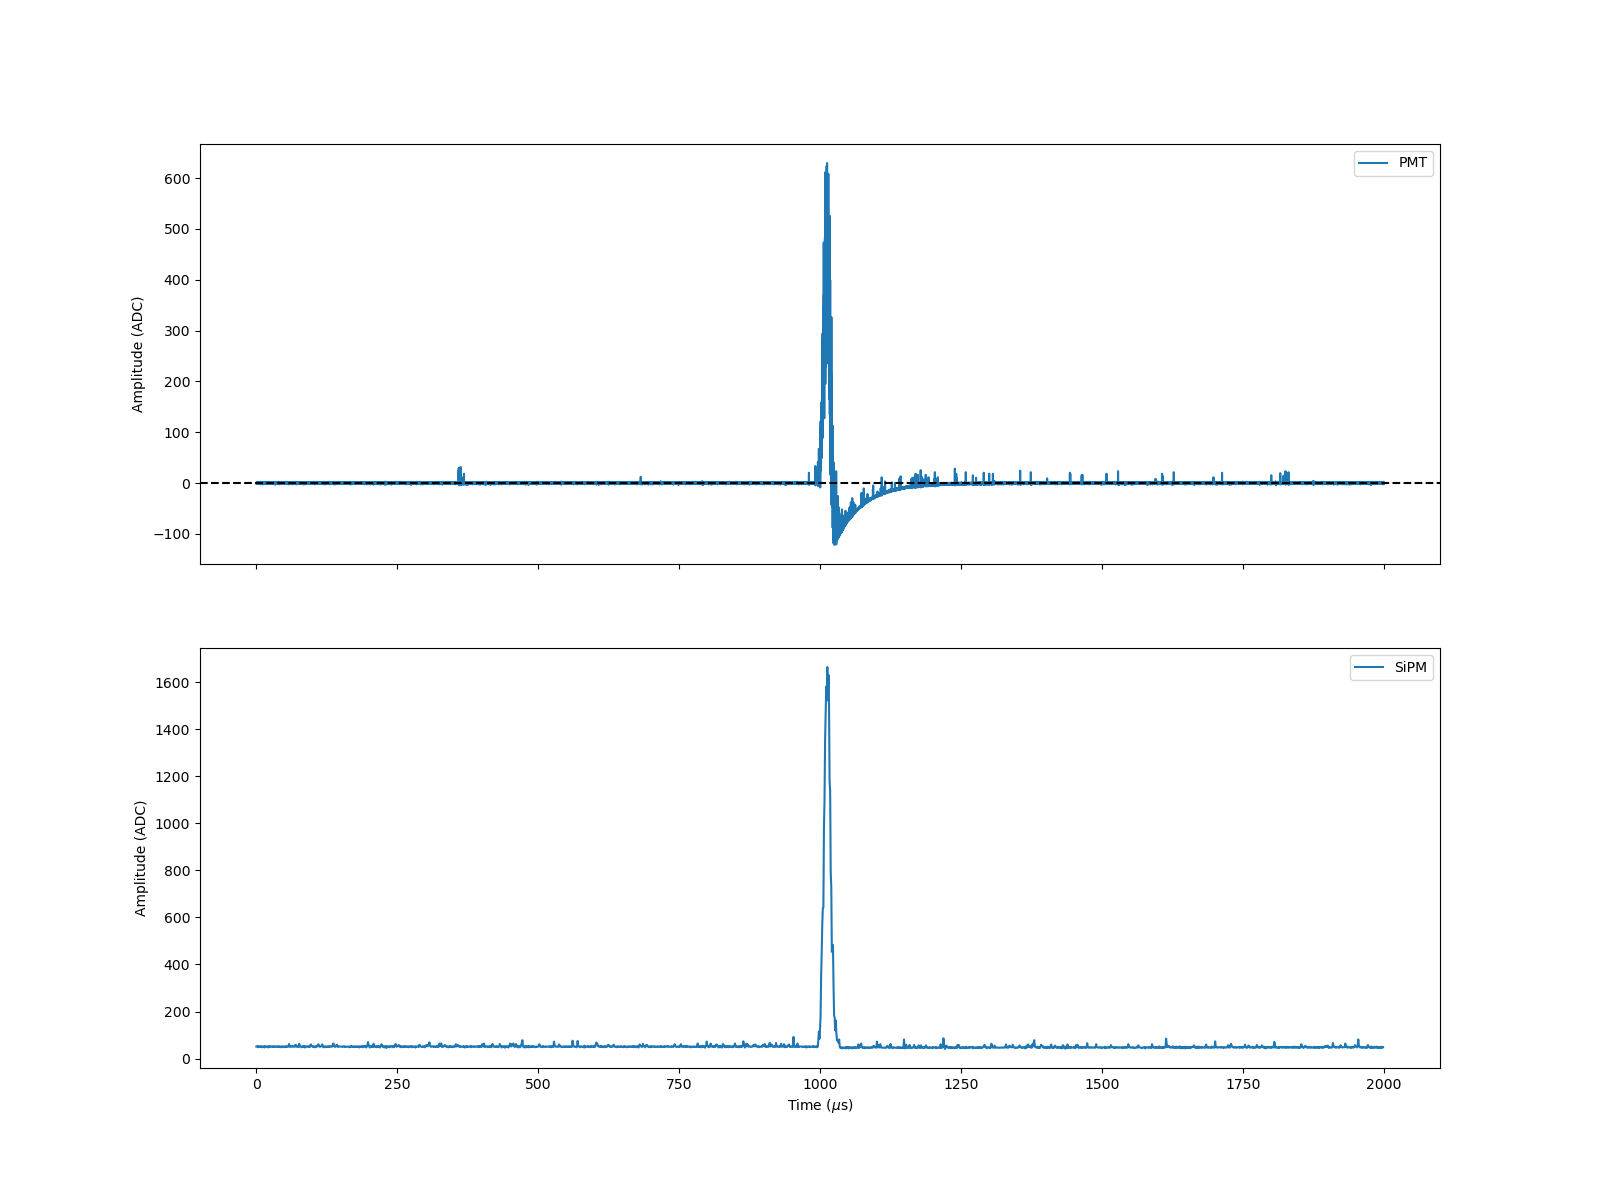

In [36]:
%matplotlib widget
# good events: 4,5,  37
event_number = 10
with tb.open_file(path) as file:
    wf_pmt  = find_highest_wf(file.root.RD. pmtrwf, event_number)
    # wf_blr  = find_highest_wf(file.root.RD. pmt_baselines, event_number)
    wf_sipm = find_highest_wf(file.root.RD.sipmrwf, event_number)

    # wf_blr_sum = [list(map(sum, zip(*rows))) for rows in zip(*file.root.RD.pmtblr[8])]

    sp_pmt  = 25e-3 # sampling period in mus
    sp_sipm = 1     # sampling period in mus
    t_pmt   = np.arange(wf_pmt .size) * sp_pmt
    t_sipm  = np.arange(wf_sipm.size) * sp_sipm


    baseline2=np.mean(wf_pmt[0:1000])
    # print(baseline2)


    wf_pmt = -1*(wf_pmt-baseline2)
    # t_pmt = t_pmt[36000:]
    # wf_pmt = wf_pmt[36000:]

    # wf_pmt = lowpass_filter(wf_pmt, 200, 1)


    _, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(16, 12))
    ax1.plot(t_pmt , wf_pmt , label = "PMT"); ax1.set_ylabel("Amplitude (ADC)")
    # ax2.plot(t_pmt , wf_blr , label = "PMT BLR"); ax2.set_ylabel("Amplitude (ADC)")
    ax3.plot(t_sipm, wf_sipm, label = "SiPM"); ax3.set_xlabel("Time ($\mu$s)");ax3.set_ylabel("Amplitude (ADC)")

    ax1.axhline(y=0, color='black', linestyle='--')

    ax1.legend(loc = "upper right")
    ax3.legend(loc = "upper right")


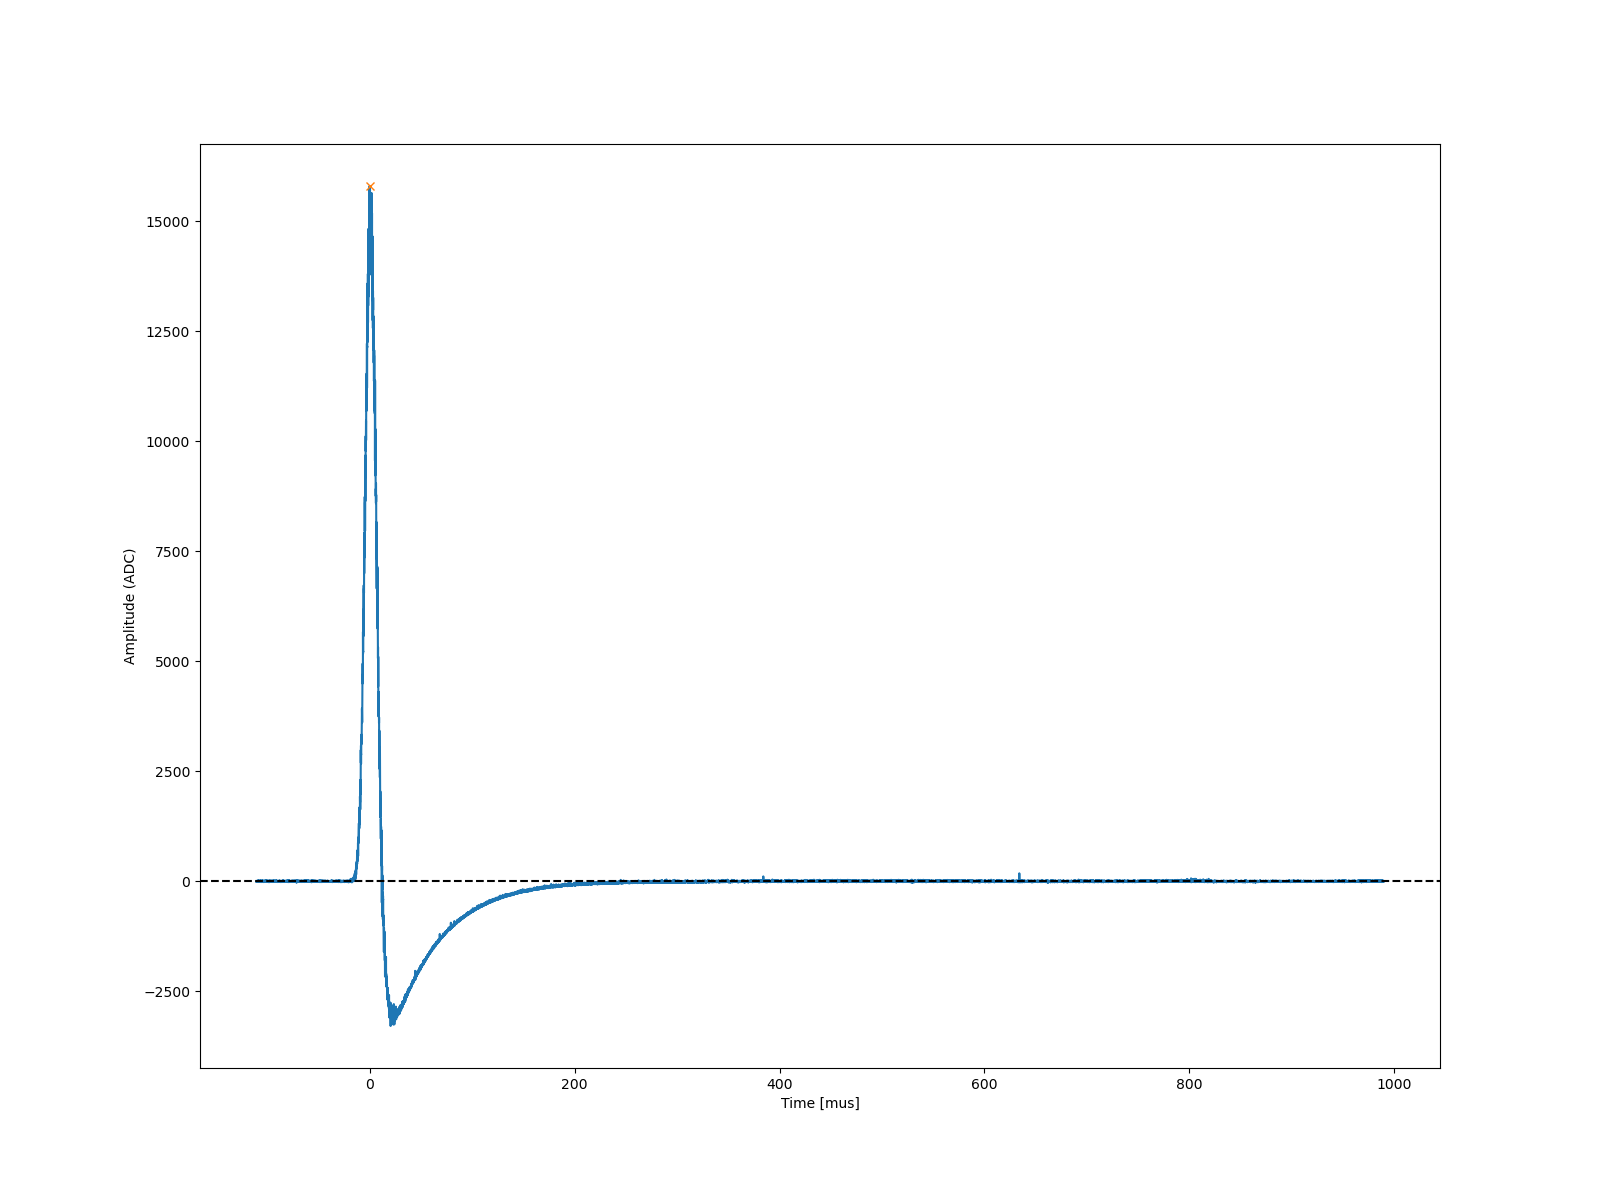

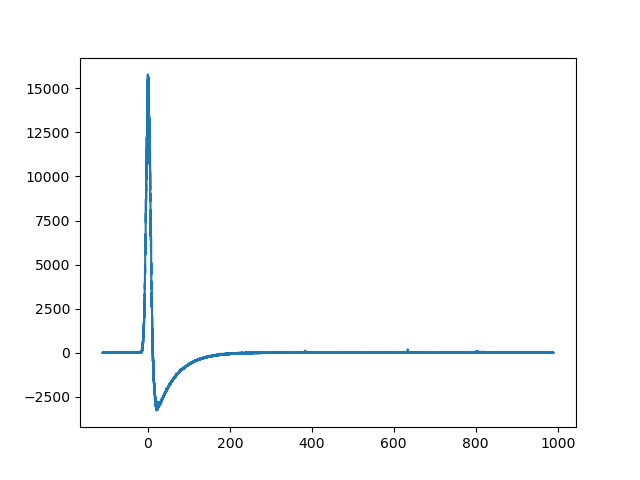

In [30]:
# good events: 4,5,  37
%matplotlib widget
event_number = 10
wf_sum=0

_, (ax1) = plt.subplots(1, 1, sharex=True, figsize=(16, 12))

for event_number in range(len(raw_evts.evt_number.unique())):
    with tb.open_file(path) as file:
        wf_pmt  = sum_wf(file.root.RD. pmtrwf, event_number)
        wf_sipm = sum_wf(file.root.RD.sipmrwf, event_number)

        # wf_blr_sum = [list(map(sum, zip(*rows))) for rows in zip(*file.root.RD.pmtblr[8])]

        if (event_number != 10):
            continue

        sp_pmt  = 25e-3 # sampling period in mus
        sp_sipm = 1     # sampling period in mus
        t_pmt   = np.arange(wf_pmt .size) * sp_pmt
        t_sipm  = np.arange(wf_sipm.size) * sp_sipm

        baseline1=np.mean(wf_pmt[79000:80000])
        # print(baseline1)
        baseline2=np.mean(wf_pmt[0:1000])
        # print(baseline2)

        if (abs(baseline1-baseline2) > 100):
            print("Error in baselines at start and end")
            print(baseline1-baseline2)
            continue
        
        wf_pmt = -1*(wf_pmt-baseline2)
        t_pmt = t_pmt[36000:]
        wf_pmt = wf_pmt[36000:]

        peaks, _ = find_peaks(wf_pmt, height=300, distance=4000)

        if (len(peaks) > 1):
            continue

        if (len(peaks) < 1):
            continue

        if (event_number==0):
            wf_sum = wf_pmt
        else:
            wf_sum = wf_sum+wf_pmt

        
        ax1.plot(t_pmt - t_pmt[peaks][0] , wf_pmt, label = "PMT"); ax1.set_ylabel("Amplitude (ADC)")
        ax1.plot(t_pmt[peaks] - t_pmt[peaks][0], wf_pmt[peaks], 'x', label='Peaks')
        # ax3.plot(t_sipm, wf_sipm, label = "SiPM"); ax3.set_xlabel("Time ($\mu$s)");ax3.set_ylabel("Amplitude (ADC)")

        # ax1.legend(loc = "upper right")
        # ax3.legend(loc = "upper right")
        # plt.savefig(f"../plots/raw/run_13852_event{event_number}.png")

        # ax1.semilogy()
        ax1.set_xlabel("Time [mus]")
        ax1.axhline(y=0, color='black', linestyle='--')



plt.figure()
plt.plot(t_pmt - t_pmt[peaks][0] , wf_sum);
# plt.semilogy()


[]

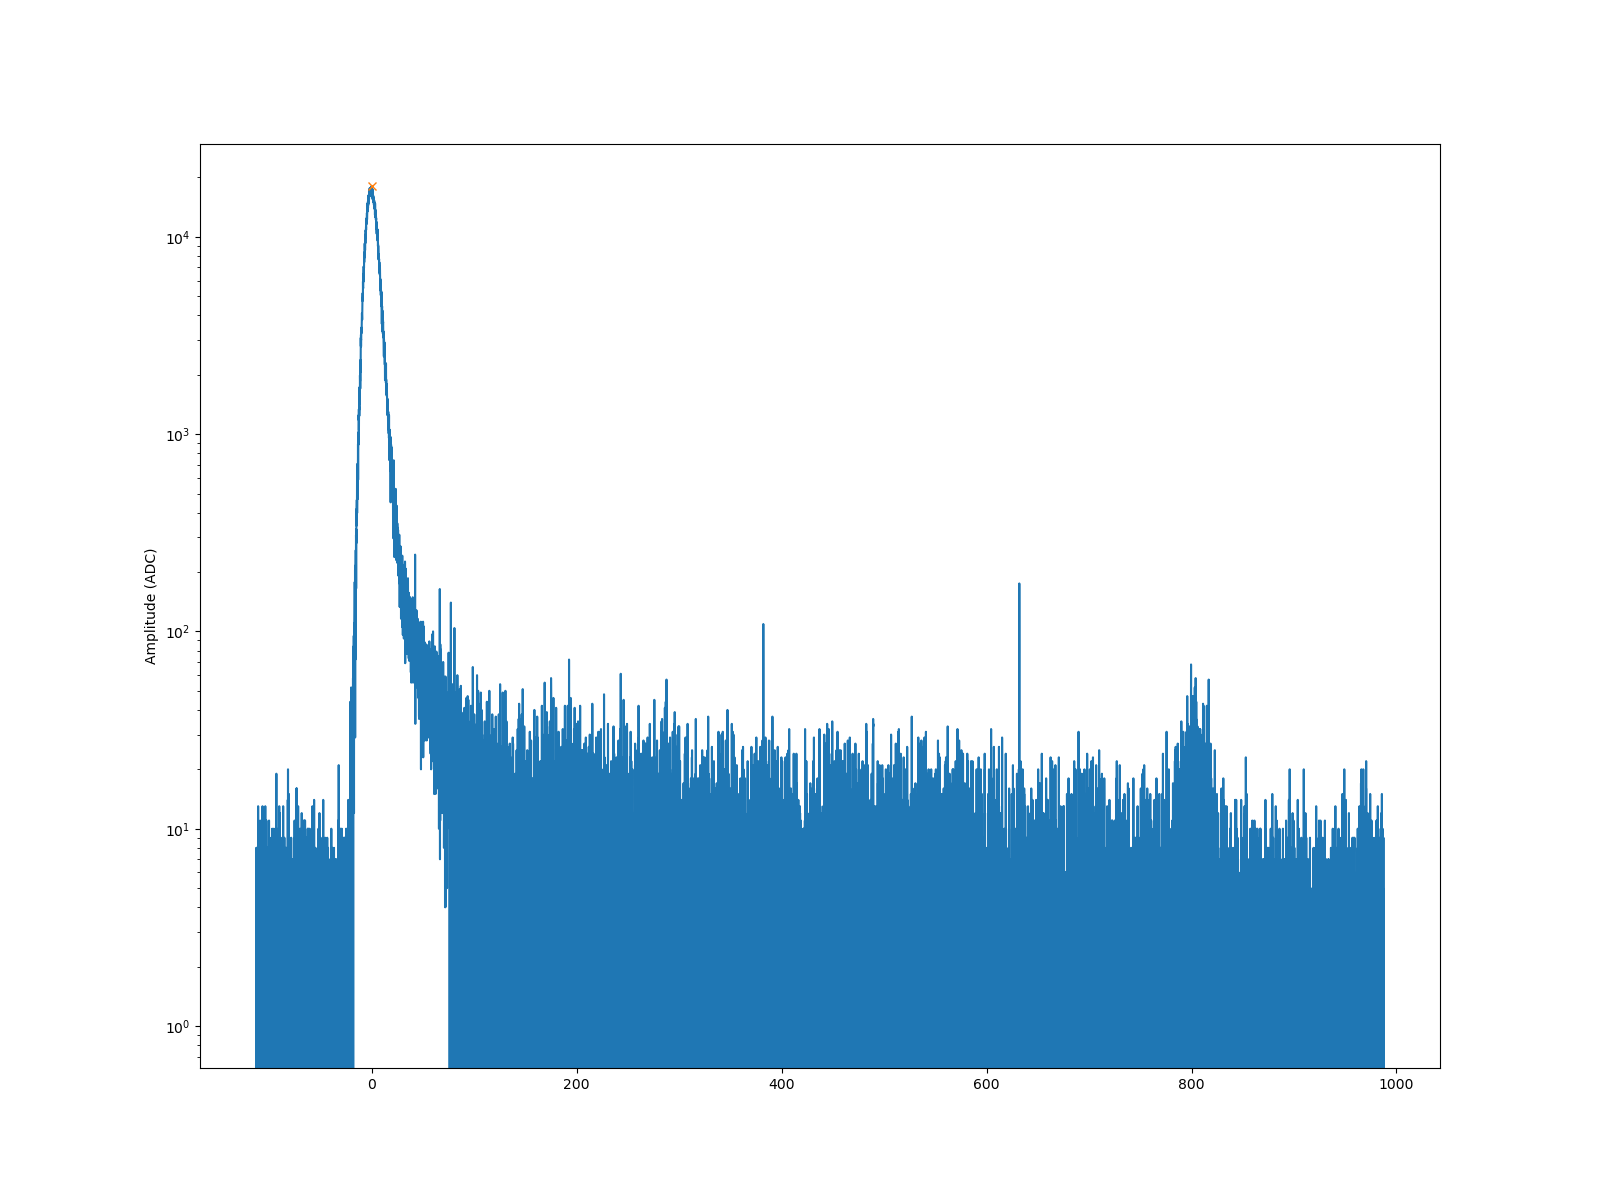

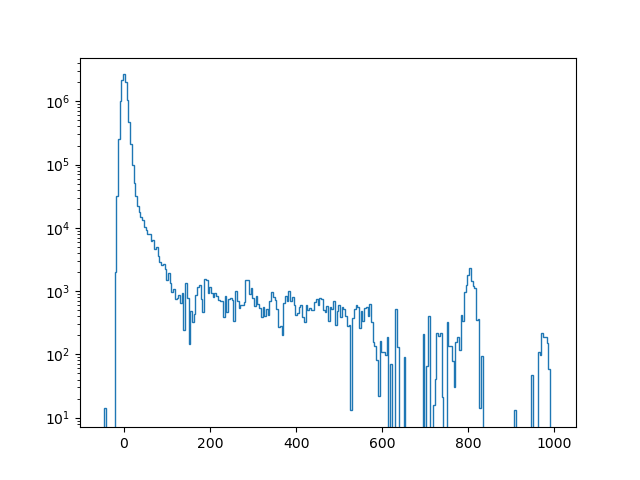

In [38]:
# Now plot BLR version of the file


%matplotlib widget
event_number = 0

output_file = "../data/run_13852_0000_ldc1_trg0_isidora.h5"
wf_blr_sum = 0

_, (ax1) = plt.subplots(1, 1, sharex=True, figsize=(16, 12))

for event_number in range(len(raw_evts.evt_number.unique())):
    with tb.open_file(output_file) as file:

        if (event_number != 10):
            continue

        wf_blr  = sum_wf(file.root.BLR. pmtcwf, event_number)
        t_pmt   = np.arange(wf_blr .size) * 25e-3 # sampling period in mus

        
        t_pmt = t_pmt[36000:]
        wf_blr = wf_blr[36000:]

        peaks, _ = find_peaks(wf_blr, height=300, distance=4000)

        if (len(peaks) > 1):
            continue

        if (len(peaks) < 1):
            continue

        if (event_number==0):
            wf_blr_sum = wf_blr
        else:
            wf_blr_sum = wf_blr_sum+wf_blr
        
        ax1.plot(t_pmt - t_pmt[peaks][0] , wf_blr, label = "PMT"); ax1.set_ylabel("Amplitude (ADC)")
        ax1.plot(t_pmt[peaks] - t_pmt[peaks][0], wf_blr[peaks], 'x', label='Peaks')
        
        # ax1.hist(t_pmt - t_pmt[peaks][0] ,weights = wf_blr, histtype = "step", bins = np.arange(-50, 1000,4));
        # ax1.set_ylabel("Amplitude (ADC)")

        # ax1.legend(loc = "upper right")

        ax1.semilogy()
        ax1.axhline(y=0, color='black', linestyle='--')



plt.figure()
plt.hist(t_pmt - t_pmt[peaks][0] ,weights = wf_blr_sum, histtype = "step", bins = np.arange(-50, 1000,4));
plt.semilogy()

In [445]:
def check_summed_baseline(wfs, grass_lim):

    flag=False
    tc=25e-3
    
    wfs_sum = sum_wf(wfs)
    
    # Check the baseline at the end and start match
    # otherwise there could be signal there so the baseline is all messed up
    baseline1=np.mean(wfs_sum[ int(1975/tc):int(2000/tc)])
    baseline2=np.mean(wfs_sum[0:int(25/tc)])

    # 20 seems like a good number to check the difference against
    if (abs(baseline1-baseline2) > 20):
        print("Error in baselines at start and end, dropping event")
        print(baseline1-baseline2)
        flag = True

    # Look in the window for large peaks that could be other S2 pulses. 
    # This will mess up the reconstruction
    peaks, _ = find_peaks(wfs_sum[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=100, distance=40/tc)

    if (len(peaks) > 1):
        flag = True

    return flag

def get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim):

    df = []

    wfs = wfs[:, tsel]

    for pmt_no, wf in enumerate(wfs):

        idx_over_thr = np.argwhere(wf > noise[pmt_no]).flatten()
        splits       = np.argwhere(np.diff(idx_over_thr) > thr_split).flatten()
        idx_slices   = np.split(idx_over_thr, splits+1)
        idx_slices   = list(filter(lambda sl: in_range(len(sl), peak_minlen, peak_maxlen + .5), idx_slices))

        for sl in idx_slices:
            m = np.argmax(wf[sl]) + sl[0]
            pe_int = wf[m-half_window:m+half_window].sum()
            df.append(pd.DataFrame(dict(event = evt_info[evt_no][0], ts_raw=ts/1e3, pmt=pmt_no, pe_int=pe_int, peak_time=m*tc+grass_lim[0], noise_thr=noise[pmt_no]), index=[0]))

    return df


In [503]:




filename  = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"
folder_out = Path("../data/analysis/")
#folder_out = Path("/tmp/")

grass_lim   = 1350, 1770 # time window in mus in which to search for single pes
noise_lim   = 1900, 2000 # time window to calculate the noise baseline
thr_1pe     = 3.5 # threshold in adc to consider a peak a 1pe candidate
thr_split   = 2 # maximum number of samples allowed to be below threshold to consider it a peak
peak_minlen = 2  # minimum number of samples above threshold in a peak
peak_maxlen = 10 # maximum number of samples above threshold in a peak
half_window = 4 # number of samples to each side of a peak maximum to integrate
n_dark      = 10 # max number of samples without pe
tc          = 25e-3 # constant to convert from samples to time or vice versa. 
noise_sigma = 4 # how many STD above noise for the single PEs to be

wf_sum = 0
wf_sum_clean = 0
wf_sum_14 = 0
wf_sum_15 = 0
wf_sum_16 = 0
wf_sum_17 = 0

deconv = deconv_pmt("next100", 13852, 62400)

data = []
data_properties = []
with tb.open_file(filename) as file:
    file_no=0
    evt_info = file.root.Run.events
    rwf      = file.root.RD.pmtrwf
    time     = np.arange(rwf.shape[2]) * tc
    tsel     = in_range(time, *grass_lim)
    for evt_no, wfs in enumerate(rwf):

        print("On Event:", evt_no)

        # if (evt_no != 66):
        #     continue

        _, ts = evt_info[evt_no]
        wfs = deconv(wfs)
        wfs_sum = sum_wf(wfs)

        # Check if  event failed the quality control
        pass_flag = check_summed_baseline(wfs, grass_lim)
        if (pass_flag):
            print("Skipping event...")
            continue

        S1, _ = find_peaks(wfs_sum[ int(100/tc):int(985/tc)], height=200, distance=40/tc)
        S2, _ = find_peaks(wfs_sum[ int(985/tc):int(1200/tc)], height=5000, distance=200/tc)

        if (len(S1) !=1 or len(S2)!=1 ):
            deltaT = 0
        else:
            deltaT = S2[0]*tc+985 - (S1[0]*tc+100)
            # print("Time difference between S1 and S2:", deltaT)

        wf_sum_14+=wfs[36]
        wf_sum_15+=wfs[15]
        wf_sum_16+=wfs[16]
        wf_sum_17+=wfs[17]
        wf_sum_clean+=wfs_sum

        # Calcilate the noise of the PMT
        noise = []
        for pmt_no, wf in enumerate(wfs):
            noise.append(noise_sigma*np.std(wf[int(noise_lim[0]/tc):int(noise_lim[1]/tc)]))


        S2_area  = wfs_sum[int(997/tc):int(1030/tc)].sum()
        cath_df = get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, [1770,1830])
        cath_df = pd.concat(cath_df, ignore_index=True)
        cath_area = cath_df.pe_int.sum()

        data_properties.append(pd.DataFrame(dict(event = evt_info[evt_no][0], S2_area=S2_area,cath_area=cath_area, ts_raw=ts/1e3, deltaT=deltaT), index=[0]))

        df = get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim)
        data = data + df

    data = pd.concat(data, ignore_index=True)
    data = data.assign(ts = np.array(list(map(datetime.fromtimestamp, data.ts_raw))))
    # data.to_hdf(file_out, "/data", complib="zlib", complevel=4, mode="w")

    data_properties = pd.concat(data_properties, ignore_index=True)
    data_properties = data_properties.assign(ts = np.array(list(map(datetime.fromtimestamp, data_properties.ts_raw))))



On Event: 0
On Event: 1
Error in baselines at start and end, dropping event
-49.498888169707506
Skipping event...
On Event: 2
On Event: 3
Error in baselines at start and end, dropping event
3694.4597917587635
Skipping event...
On Event: 4
On Event: 5
On Event: 6
On Event: 7
On Event: 8
On Event: 9
On Event: 10
Skipping event...
On Event: 11
Skipping event...
On Event: 12
On Event: 13
On Event: 14
Skipping event...
On Event: 15
Skipping event...
On Event: 16
On Event: 17
On Event: 18
On Event: 19
Skipping event...
On Event: 20
Skipping event...
On Event: 21
On Event: 22
Skipping event...
On Event: 23
On Event: 24
On Event: 25
On Event: 26
On Event: 27
Skipping event...
On Event: 28
On Event: 29
On Event: 30
On Event: 31
On Event: 32
On Event: 33
On Event: 34
On Event: 35
On Event: 36
On Event: 37
On Event: 38
On Event: 39
Error in baselines at start and end, dropping event
-33.664563494276365
Skipping event...
On Event: 40
On Event: 41
Skipping event...
On Event: 42
Error in baselines a

In [504]:
display(data)
display(data_properties)

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,2,1.717754e+09,0,34.113824,1350.625,3.769949,2024-06-07 04:48:07.489
1,2,1.717754e+09,0,48.378860,1393.075,3.769949,2024-06-07 04:48:07.489
2,2,1.717754e+09,0,48.434409,1400.175,3.769949,2024-06-07 04:48:07.489
3,2,1.717754e+09,0,53.154394,1441.500,3.769949,2024-06-07 04:48:07.489
4,2,1.717754e+09,0,48.181904,1461.150,3.769949,2024-06-07 04:48:07.489
...,...,...,...,...,...,...,...
48500,597,1.717754e+09,59,12.647179,1435.925,3.701920,2024-06-07 04:48:39.287
48501,597,1.717754e+09,59,55.319567,1593.525,3.701920,2024-06-07 04:48:39.287
48502,597,1.717754e+09,59,56.477167,1612.975,3.701920,2024-06-07 04:48:39.287
48503,597,1.717754e+09,59,48.633736,1619.500,3.701920,2024-06-07 04:48:39.287


,event,S2_area,cath_area,ts_raw,deltaT,ts
0,2,9.436224e+06,39530.801913,1.717754e+09,801.150,2024-06-07 04:48:07.489
1,16,1.097003e+07,42284.162037,1.717754e+09,160.025,2024-06-07 04:48:08.115
2,30,1.071701e+07,37674.395879,1.717754e+09,174.300,2024-06-07 04:48:08.983
3,37,1.242046e+07,55142.976885,1.717754e+09,0.000,2024-06-07 04:48:09.496
4,44,9.273778e+06,36193.596328,1.717754e+09,436.575,2024-06-07 04:48:09.855
...,...,...,...,...,...,...
59,569,3.792086e+06,18557.857278,1.717754e+09,801.350,2024-06-07 04:48:37.928
60,576,1.288712e+07,52574.847179,1.717754e+09,192.475,2024-06-07 04:48:38.190
61,583,7.615632e+06,29427.542475,1.717754e+09,315.850,2024-06-07 04:48:38.662
62,590,9.702149e+06,38679.960358,1.717754e+09,798.125,2024-06-07 04:48:39.011


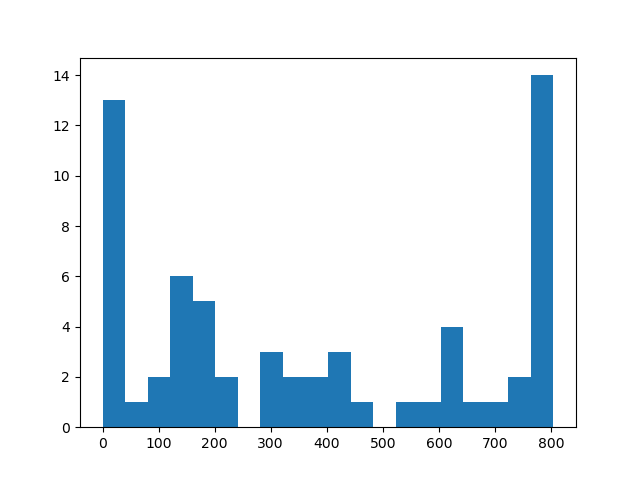

In [507]:
plt.figure()
plt.hist(data_properties.deltaT, bins = 20);

AttributeError: 'list' object has no attribute 'S2_area'

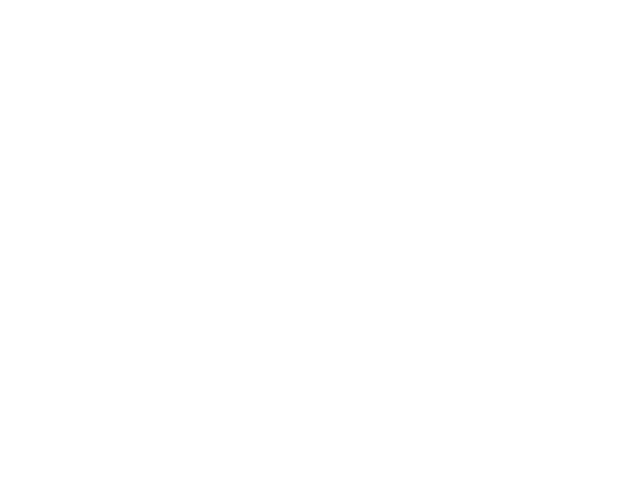

In [485]:
plt.figure()
plt.scatter(data_properties.S2_area, data_properties.cath_area)
plt.xlabel("S2 Pulse Area [ADC]")
plt.ylabel("Cathode PE Area [ADC]")

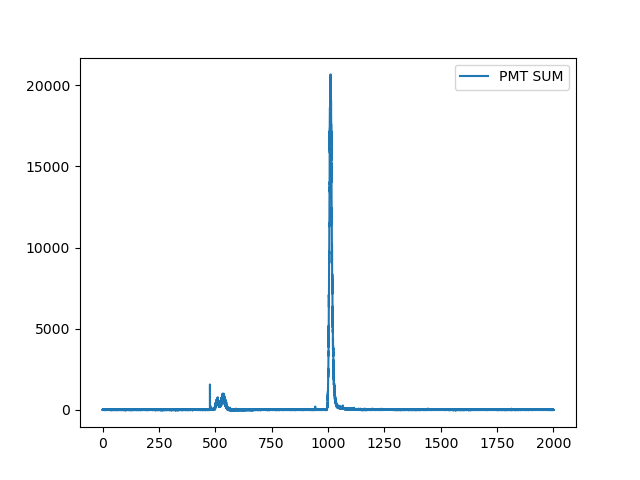

In [500]:
plt.figure()
t_pmt   = np.arange(wf_sum_14 .size) * 25e-3 # sampling period in mus

# plt.plot(t_pmt , wf_sum_14, label = "PMT 14");
# plt.plot(t_pmt , wf_sum_15, label = "PMT 15");
plt.plot(t_pmt , wf_sum_clean, label = "PMT SUM");

# peaks, _ = find_peaks(wf_sum_15[ int(grass_lim[0]/25e-3):int(grass_lim[1]/25e-3)], height=noise[15], distance=1/25e-3)


# plt.plot(t_pmt , wf_sum_15, label = "PMT 42");
# plt.plot(t_pmt[peaks+int(grass_lim[0]/25e-3)], wf_sum_15[peaks+int(grass_lim[0]/25e-3)], 'x', label='Peaks')
# plt.plot(t_pmt , wf_sum_17, label = "PMT 17");

plt.legend()

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,2,1.717754e+09,0,34.113824,1350.625,3.769949,2024-06-07 04:48:07.489
1,2,1.717754e+09,0,48.378860,1393.075,3.769949,2024-06-07 04:48:07.489
2,2,1.717754e+09,0,48.434409,1400.175,3.769949,2024-06-07 04:48:07.489
3,2,1.717754e+09,0,53.154394,1441.500,3.769949,2024-06-07 04:48:07.489
4,2,1.717754e+09,0,48.181904,1461.150,3.769949,2024-06-07 04:48:07.489
...,...,...,...,...,...,...,...
48500,597,1.717754e+09,59,12.647179,1435.925,3.701920,2024-06-07 04:48:39.287
48501,597,1.717754e+09,59,55.319567,1593.525,3.701920,2024-06-07 04:48:39.287
48502,597,1.717754e+09,59,56.477167,1612.975,3.701920,2024-06-07 04:48:39.287
48503,597,1.717754e+09,59,48.633736,1619.500,3.701920,2024-06-07 04:48:39.287


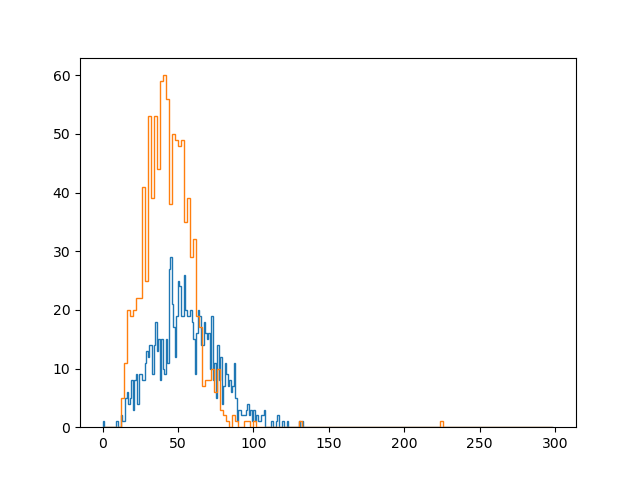

In [461]:
display(data)
plt.figure()
# for pmt in data.pmt.unique():
    # if (pmt <= 50 and pmt >= 49):
    # plt.hist(data[data.pmt == pmt].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = pmt);


# plt.hist(data[data.pmt == 0].pe_int, bins = np.arange(0, 300, 1), histtype = "step",  label = "PMT 12");
# plt.hist(data[data.pmt == 1].pe_int, bins = np.arange(0, 300, 1), histtype = "step",  label = "PMT 13");
# plt.hist(data[data.pmt == 2].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 14");
# plt.hist(data[data.pmt == 3].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 15");
plt.hist(data[data.pmt == 4].pe_int, bins = np.arange(0, 300, 1), histtype = "step");
plt.hist(data[data.pmt == 10].pe_int, bins = np.arange(0, 300, 2), histtype = "step");




# plt.legend()

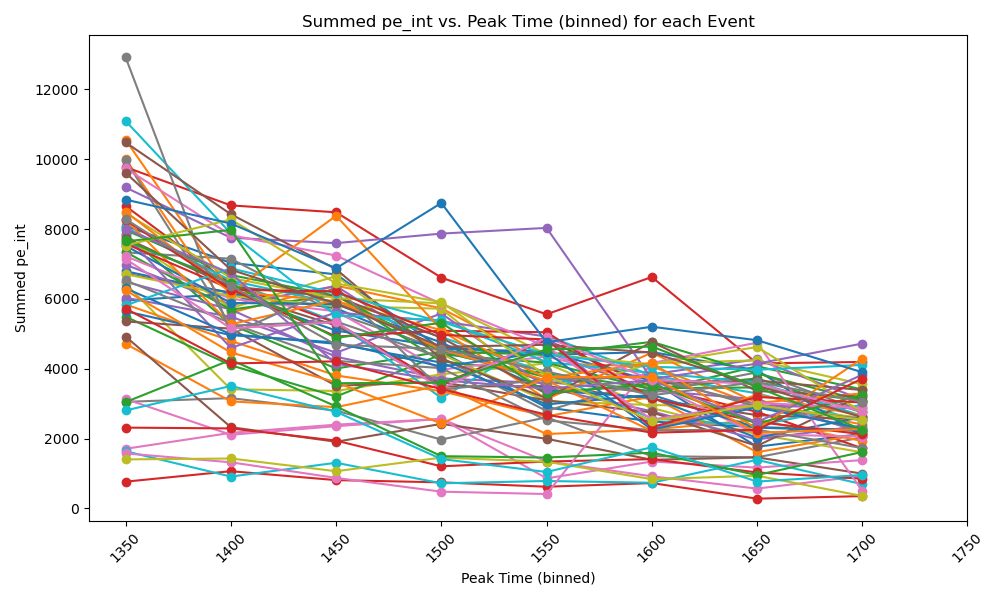

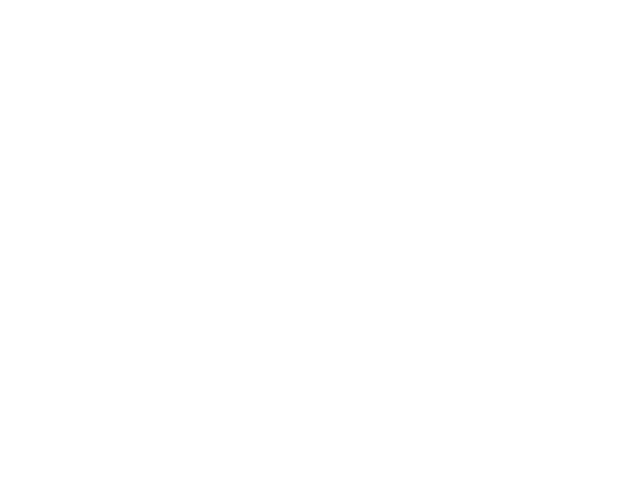

In [467]:
# Plot the PE charge vs time in the window
plt.figure()

# 1. Group by 'event' and sum 'pe_int' for each event
# summed_pe_int = data.groupby('event')['pe_int'].sum()

# 1. Define bins for peak_time from 1350 to 1770 in steps of 10
bins = np.arange(1350, 1780, 50)  # Bins from 1350 to 1770 with step of 10
data['peak_time_bin'] = pd.cut(data['peak_time'], bins, include_lowest=True, labels=bins[:-1])

# 2. Group by 'event' and 'peak_time_bin', then sum 'pe_int'
grouped = data.groupby(['event', 'peak_time_bin'])['pe_int'].sum().reset_index()

# 3. Plot each event as a separate curve
plt.figure(figsize=(10, 6))

for event in grouped['event'].unique():
    event_data = grouped[grouped['event'] == event]
    plt.plot(event_data['peak_time_bin'], event_data['pe_int'], marker='o', linestyle='-', label=f'Event {event}')

# 4. Customize plot
plt.xlabel('Peak Time (binned)')
plt.ylabel('Summed pe_int')
plt.title('Summed pe_int vs. Peak Time (binned) for each Event')
plt.xticks(bins, rotation=45)
# plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()



